# 使用os包中的API-终于到这里了

我们今天要讲的是`os`代码包中的API。这个代码包可以让我们拥有操控计算机操作系统的能力。

## 前导内容：os包中的API

这个代码包提供的都是平台不相关的`API`。那么说，什么叫平台不相关的`API`呢？

它的意思是：这些`API`基于（或者说抽象自）操作系统，为我们使用操作系统的功能提供高层次的支持，但是，它们并不依赖于具体的操作系统。

不论是`Linux、macOS、Windows`，还是`FreeBSD、OpenBSD、Plan9`，`os`代码包都可以为之提供统一的使用接口。这使得我们可以用同样的方式，来操纵不同的操作系统，并得到相似的结果。

`os`包中的`API`主要可以**帮助我们使用操作系统中的文件系统、权限系统、环境变量、系统进程以及系统信号**。

其中，操纵文件系统的`API`最为丰富。我们不但可以利用这些`API`创建和删除文件以及目录，还可以获取到它们的各种信息、修改它们的内容、改变它们的访问权限，等等。

说到这里，就不得不提及一个**非常常用**的数据类型：`os.File`。

从字面上来看，`os.File`类型代表了操作系统中的文件。但实际上，它可以代表的远不止于此。或许你已经知道，对于类Unix的操作系统（包括Linux、macOS、FreeBSD等），其中的一切都可以被看做是文件。

除了文本文件、二进制文件、压缩文件、目录这些常见的形式之外，还有符号链接、各种物理设备（包括内置或外接的面向块或者字符的设备）、命名管道，以及套接字（也就是`socket`），等等。

因此，可以说，我们能够利用`os.File`类型操纵的东西太多了。不过，为了聚焦于`os.File`本身，同时也为了让本文讲述的内容更加通用，我们在这里主要把`os.File`类型应用于常规的文件。

下面这个问题，就是以`os.File`类型代表的最基本内容入手。**我们今天的问题是：`os.File`类型都实现了哪些`io`包中的接口？**

**这道题的典型回答是这样的。**

`os.File`类型拥有的都是指针方法，所以除了空接口之外，它本身没有实现任何接口。而它的指针类型则实现了很多`io`代码包中的接口。

首先，对于`io`包中最核心的3个简单接口`io.Reader`、`io.Writer`和`io.Closer`，`*os.File`类型都实现了它们。

其次，该类型还实现了另外的3个简单接口，即：`io.ReaderAt`、`io.Seeker`和`io.WriterAt`。

正是因为`*os.File`类型实现了这些简单接口，所以它也顺便实现了`io`包的9个扩展接口中的7个。

然而，由于它并没有实现简单接口`io.ByteReader`和`io.RuneReader`，所以它没有实现分别作为这两者的扩展接口的`io.ByteScanner`和`io.RuneScanner`。

总之，`os.File`类型及其指针类型的值，**不但可以通过各种方式读取和写入某个文件中的内容，还可以寻找并设定下一次读取或写入时的起始索引位置，另外还可以随时对文件进行关闭。**

但是，它们并不能专门地读取文件中的下一个字节，或者下一个Unicode字符，也不能进行任何的读回退操作。

不过，单独读取下一个字节或字符的功能也可以通过其他方式来实现，比如，调用它的`Read`方法并传入适当的参数值就可以做到这一点。

## 问题解析

这个问题其实在间接地问“`os.File`类型能够以何种方式操作文件？”我在前面的典型回答中也给出了简要的答案。

在我进一步地说明一些细节之前，我们先来看看，怎样才能获得一个`os.File`类型的指针值（以下简称`File`值）。

在`os`包中，有这样几个函数，即：`Create`、`NewFile`、`Open`和`OpenFile`。

**`os.Create`函数用于根据给定的路径创建一个新的文件。 它会返回一个File值和一个错误值。我们可以在该函数返回的File值之上，对相应的文件进行读操作和写操作。**

不但如此，我们使用这个函数创建的文件，对于操作系统中的所有用户来说，都是可以读和写的。

换句话说，一旦这样的文件被创建出来，任何能够登录其所属的操作系统的用户，都可以在任意时刻读取该文件中的内容，或者向该文件写入内容。

注意，如果在我们给予`os.Create`函数的路径之上，已经存在了一个文件，**那么该函数会先清空现有文件中的全部内容，然后再把它作为第一个结果值返回。**

另外，`os.Create`函数是有可能返回非`nil`的错误值的。

比如，如果我们给定的路径上的某一级父目录并不存在，那么该函数就会返回一个`*os.PathError`类型的错误值，以表示“不存在的文件或目录”。

再来看`os.NewFile`函数。 该函数在被调用的时候，需要接受一个代表文件描述符的、`uintptr`类型的值，以及一个用于表示文件名的字符串值。

如果我们给定的文件描述符并不是有效的，那么这个函数将会返回`nil`，否则，它将会返回一个代表了相应文件的`File`值。

注意，不要被这个函数的名称误导了，**它的功能并不是创建一个新的文件，而是依据一个已经存在的文件的描述符，来新建一个包装了该文件的File值。**

例如，我们可以像这样拿到一个包装了标准错误输出的File值：

In [ ]:
file3 := os.NewFile(uintptr(syscall.Stderr), "/dev/stderr")

然后，通过这个File值向标准错误输出上写入一些内容：

In [ ]:
if file3 != nil {
 defer file3.Close()
 file3.WriteString(
  "The Go language program writes the contents into stderr.\n")
}

`os.Open`函数会打开一个文件并**返回**包装了该文件的`File`值。 然而，该函数只能以只读模式打开文件。换句话说，我们只能从该函数返回的`File`值中读取内容，而不能向它写入任何内容。

如果我们调用了这个`File`值的任何一个写入方法，那么都将会得到一个表示了“坏的文件描述符”的错误值。实际上，我们刚刚说的只读模式，正是应用在`File`值所持有的文件描述符之上的。

**所谓的文件描述符，是由通常很小的非负整数代表的。它一般会由`I/O`相关的系统调用返回，并作为某个文件的一个标识存在。**

从操作系统的层面看，针对任何文件的I/O操作都需要用到这个`文件描述符`。只不过，`Go`语言中的一些数据类型，为我们隐匿掉了这个描述符，如此一来我们就无需时刻关注和辨别它了（就像`os.File`类型这样）。

实际上，我们在调用前文所述的`os.Create`函数、`os.Open`函数以及将会提到的`os.OpenFile`函数的时候，它们都会执行同一个系统调用，并且在成功之后得到这样一个文件描述符。这个文件描述符将会被储存在它们返回的`File`值中。

`os.File`类型有一个指针方法，名叫`Fd`。它在被调用之后将会返回一个`uintptr`类型的值。这个值就代表了当前的`File`值所持有的那个文件描述符。

不过，在`os`包中，除了`NewFile`函数需要用到它，它也没有什么别的用武之地了。所以，如果你操作的只是常规的文件或者目录，那么就无需特别地在意它了。

最后，再说一下`os.OpenFile`函数。 这个函数其实是`os.Create`函数和`os.Open`函数的底层支持，它最为灵活。

这个函数有3个参数，分别名为`name`、`flag`和`perm`。其中的`name`指代的就是文件的路径。而`flag`参数指的则是需要施加在文件描述符之上的模式，我在前面提到的只读模式就是这里的一个可选项。

在`Go`语言中，这个只读模式由常量`os.O_RDONLY`代表，它是`int`类型的。当然了，这里除了只读模式之外，还有几个别的模式可选，我们稍后再细说。

`os.OpenFile`函数的参数`perm`代表的也是模式，它的类型是`os.FileMode`，此类型是一个基于`uint32`类型的再定义类型。

为了加以区别，我们把参数`flag`指代的模式叫`做操作模式`，而把参数`perm`指代的模式叫做`权限模式`。可以这么说，操作模式限定了操作文件的方式，而权限模式则可以控制文件的`访问权限`。关于权限模式的更多细节我们将在后面讨论。

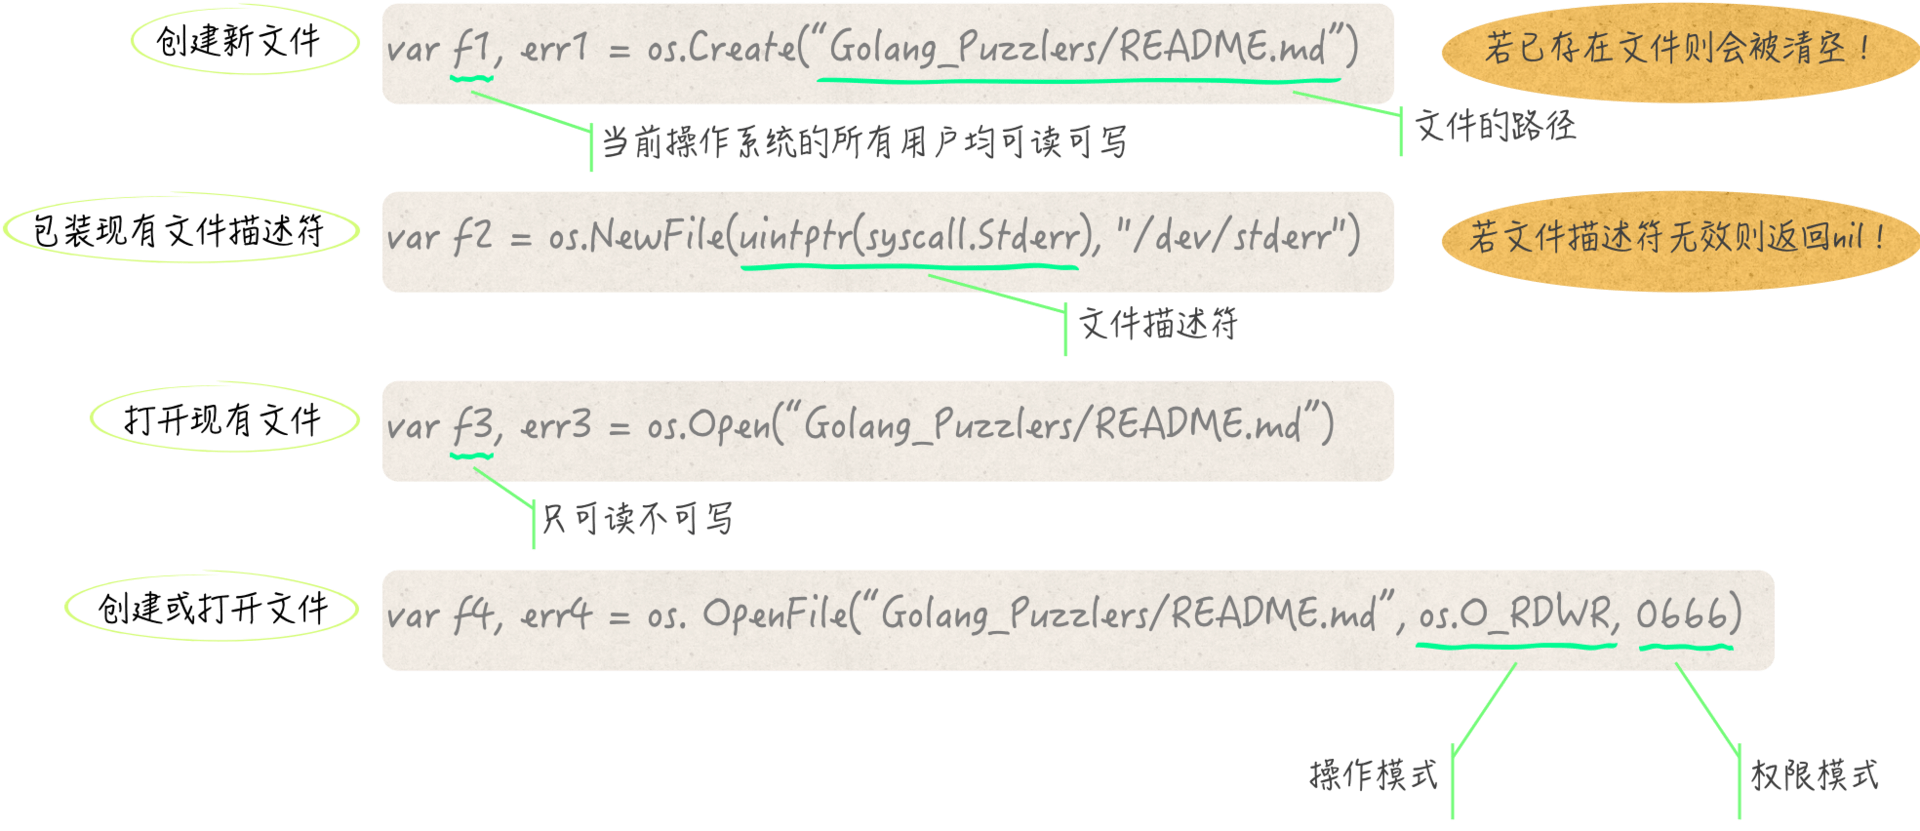
- （获得os.File类型的指针值的几种方式）

到这里，你需要记住的是，通过`os.File`类型的值，我们不但可以对文件进行读取、写入、关闭等操作，还可以设定下一次读取或写入时的起始索引位置。

此外，`os`包中还有用于创建全新文件的`Create`函数，用于包装现存文件的`NewFile`函数，以及可被用来打开已存在的文件的`Open`函数和`OpenFile`函数。

## 总结
我们今天讲的是`os`代码包以及其中的程序实体。我们首先讨论了`os`包存在的意义，和它的主要用途。代码包中所包含的`API`，都是对操作系统的某方面功能的高层次抽象，这使得我们可以通过它以统一的方式，操纵不同的操作系统，并得到相似的结果。

在这个代码包中，操纵文件系统的`API`最为丰富，最有代表性的就是数据类型`os.File`。`os.File`类型不但可以代表操作系统中的文件，还可以代表很多其他的东西。尤其是在类Unix的操作系统中，它几乎可以代表一切可以操纵的软件和硬件。

# - 下
我们在上一篇文章中。从“`os.File`类型都实现了哪些`io`包中的接口”这一问题出发，介绍了一系列的相关内容。今天我们继续围绕这一知识点进行扩展。

## 知识扩展
**问题1：可应用于File值的操作模式都有哪些？**

针对`File`值的操作模式主要有**只读模式、只写模式和读写模式**。

这些模式分别由常量`os.O_RDONLY`、`os.O_WRONLY`和`os.O_RDWR`代表。在我们新建或打开一个文件的时候，必须把这三个模式中的一个设定为此文件的操作模式。

除此之外，我们还可以为这里的文件设置额外的操作模式，可选项如下所示。

- `os.O_APPEND`：当向文件中写入内容时，把新内容追加到现有内容的后边。
- `os.O_CREATE`：当给定路径上的文件不存在时，创建一个新文件。
- `os.O_EXCL`：需要与`os.O_CREATE`一同使用，表示在给定的路径上不能有已存在的文件。
- `os.O_SYNC`：在打开的文件之上实施同步`I/O`。它会保证读写的内容总会与硬盘上的数据保持同步。
- `os.O_TRUNC`：如果文件已存在，并且是常规的文件，那么就先清空其中已经存在的任何内容。
对于以上操作模式的使用，`os.Create`函数和`os.Open`函数都是现成的例子。

In [ ]:
func Create(name string) (*File, error) {
 return OpenFile(name, O_RDWR|O_CREATE|O_TRUNC, 0666)
}

`os.Create`函数在调用`os.OpenFile`函数的时候，给予的操作模式是`os.O_RDWR`、`os.O_CREATE`和`os.O_TRUNC`的组合。

这就基本上决定了前者的行为，即：如果参数`name`代表路径之上的文件不存在，那么就新建一个，否则，先清空现存文件中的全部内容。

并且，它返回的`File`值的读取方法和写入方法都是可用的。这里需要注意，多个操作模式是通过按位**或**操作符`|`组合起来的。

func Open(name string) (*File, error) {- return OpenFile(name, O_RDONLY, 0)- }

我在前面说过，`os.Open`函数的功能是：以**只读**模式打开已经存在的文件。其根源就是它在调用os.OpenFile函数的时候，只提供了一个单一的操作模式`os.O_RDONLY`。

以上，就是我对可应用于`File`值的操作模式的简单解释。在demo88.go文件中还有少许示例，可供你参考。

**问题2：怎样设定常规文件的访问权限？**

我们已经知道，`os.OpenFile`函数的第三个参数`perm`代表的是权限模式，其类型是`os.FileMode`。但实际上，`os.FileMode`类型能够代表的，可远不只权限模式，它还可以代表**文件模式（也可以称之为文件种类）**。

由于`os.FileMode`是基于`uint32`类型的再定义类型，所以它的每个值都包含了`32`个比特位。在这`32`个比特位当中，每个比特位都有其特定的含义。

比如，如果在其最高比特位上的二进制数是`1`，那么该值表示的文件模式就等同于`os.ModeDir`，也就是说，相应的文件代表的是`一个目录`。

又比如，如果其中的第`26`个比特位上的是`1`，那么相应的值表示的文件模式就等同于`os.ModeNamedPipe`，也就是说，那个文件代表的是一个`命名管道`。

实际上，在一个`os.FileMode`类型的值（以下简称FileMode值）中，只有最低的`9`个比特位才用于表示文件的权限。当我们拿到一个此类型的值时，可以把它和`os.ModePerm`常量的值做按位与操作。

这个常量的值是`0777`，是一个八进制的无符号整数，其最低的`9`个比特位上都是`1`，而更高的`23`个比特位上都是`0`。

所以，经过这样的按位与操作之后，我们即可得到这个`FileMode`值中所有用于表示`文件权限`的比特位，也就是该值所表示的权限模式。这将会与我们调用`FileMode`值的`Perm`方法所得到的结果值是一致。

在这`9`个用于表示文件权限的比特位中，每`3`个比特位为一组，共可分为`3`组。

从高到低，这`3`组分别表示的是
1. 文件所有者（也就是创建这个文件的那个用户）、
2. 文件所有者所属的用户组，
3. 以及其他用户对该文件的访问权限。
**而对于每个组，其中的3个比特位从高到低分别表示读权限、写权限和执行权限。**

如果在其中的某个比特位上的是1，那么就意味着相应的权限`开启`，否则，就表示相应的权限`关闭`。

因此，八进制整数`0777`就表示：操作系统中的所有用户都对当前的文件有读、写和执行的权限，而八进制整数`0666`则表示：所有用户都对当前文件有读和写的权限，但都没有执行的权限。

我们在调用`os.OpenFile`函数的时候，可以根据以上说明设置它的第三个参数。但要注意，只有在**新建文件**的时候，这里的第三个参数值才是有效的。在其他情况下，即使我们设置了此参数，也不会对目标文件产生任何的影响。

## 总结
为了聚焦于`os.File`类型本身，我在这两篇文章中主要讲述了怎样把`os.File`类型应用于常规的文件。该类型的指针类型实现了很多`io`包中的接口，因此它的具体功用也就可以不言自明了。

通过该类型的值，我们不但可以对文件进行各种读取、写入、关闭等操作，还可以设定下一次读取或写入时的起始索引位置。

在使用这个类型的值之前，我们必须先要创建它。所以，我为你重点介绍了几个可以创建，并获得此类型值的函数。

包括：`os.Create`、`os.NewFile`、`os.Open`和`os.OpenFile`。我们用什么样的方式创建`File`值，就决定了我们可以使用它来做什么。

利用`os.Create`函数，我们可以在操作系统中创建一个全新的文件，或者清空一个现存文件中的全部内容并重用它。

在相应的`File`值之上，我们可以对该文件进行任何的读写操作。虽然`os.NewFile`函数并不是被用来创建新文件的，但是它能够基于一个有效的文件描述符包装出一个可用的`File`值。

`os.Open`函数的功能是打开一个已经存在的文件。但是，我们只能通过它返回的`File`值对相应的文件进行读操作。

`os.OpenFile`是这些函数中最为灵活的一个，通过它，我们可以设定被打开文件的操作模式和权限模式。**实际上，`os.Create`函数和`os.Open`函数都只是对它的简单封装而已**。

在使用`os.OpenFile`函数的时候，我们必须要搞清楚操作模式和权限模式所代表的真正含义，以及设定它们的正确方式。

我在本文的扩展问题中分别对它们进行了较为详细的解释。同时，我在对应的示例文件中也编写了一些代码。

你需要认真地阅读和理解这些代码，并在运行它们的过程当中悟出这两种模式的真谛。

我在本文中讲述的东西对于`os`包来说，只是海面上的那部分冰山而已。这个代码包囊括的知识众多，而且延展性都很强。

如果你想完全理解它们，可能还需要去参看操作系统等方面的文档和教程。由于篇幅原因，我在这里只是做了一个引导，帮助你初识该包中的一些重要的程序实体，并给予你一个可以深入下去的切入点，希望你已经在路上了。

## 思考题
今天的思考题是：怎样通过os包中的API创建和操纵一个系统进程？

答：你可以从os包的FindProcess函数和StartProcess函数开始。前者用于通过进程ID（pid）查找进程，后者用来基于某个程序启动一个进程。

这两者都会返回一个*os.Process类型的值。该类型提供了一些方法，比如，用于杀掉当前进程的Kill方法，又比如，可以给当前进程发送系统信号的Signal方法，以及会等待当前进程结束的Wait方法。

与此相关的还有os.ProcAttr类型、os.ProcessState类型、os.Signal类型，等等。你可以通过积极的实践去探索更多的玩法。